## Testing the new agent implementation

In [1]:
import sys
import pickle 
import os
print(sys.prefix)
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd

from functools import partial

import importlib   # To import model files with poorly written names  ¯\_(ツ)_/¯
from tabulate import tabulate # to make pretty tables : 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# To make nice plots : 
from simulate.plot_trajectory import plot_training

# To extract the data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from analysis_tools.preprocess import get_preprocessed_data_from_df
from utils import remove_by_indices

# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,simulate_training
from simulate.compute_likelihood_full_actions import compute_predicted_actions
from simulate.general_agent import Agent


# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from simulate.invert_model import invert_data_for_library_of_models

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# environment constants :
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD =  0.175#0.025#0.175#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(a,b,c,d,e,u,T,NTRIALS)



In [3]:
No = N_FEEDBACK_OUTCOMES
Ns = 5

MODEL_CONSTANTS = {
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns
    },
}
agent_options = {
    "model_family" : "latql",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : ["static","initial"],
    "assymetric_learning_rate" : True,
    "modality_selector" : {
        "learn" : True,
        "metric" : "q_value", #""js_controll", "q_value","surprisal"
        "biaises" : ["initial"],
        "focused_learning" : True,
        "independent_focused_learning_weights" : True
    },
    "cross_state_generalize" : True
}

agent_options = {
    "model_family" : "rw",  # "rw" / "latql" / "tracking_rw"
    "free_parameters" : "mixed",
    "biaises" : [],
    "assymetric_learning_rate" : True,
    "modality_selector" : None,
    "cross_state_generalize" : False
}

agent = Agent(agent_options,MODEL_CONSTANTS)

# print(agent.get_default_parameters())
# print(agent.get_random_parameters(jr.PRNGKey(10)))


hyperparams = agent.get_random_parameters(jr.PRNGKey(10))
all_functions = agent.get_all_functions(hyperparams)

print(hyperparams)

{'alpha_Q+': Array([0.01666343], dtype=float32), 'alpha_Q-': Array([0.00161831], dtype=float32), 'beta_Q': Array([8.646248], dtype=float32), 'position': {}, 'angle': {}, 'distance': {}}


In [4]:
hyperparams = {
    "alpha_Q+" : jnp.array([0.1]),
    "alpha_Q-" : jnp.array([0.2]),
    "beta_Q" : jnp.array([500]),
}

final_parameters,(environment_variables,agent_variables) = simulate_training(ENVIRONMENT.get_functions(),agent.get_all_functions(hyperparams),
                  jr.PRNGKey(0),n_trials=NTRIALS,n_observations_per_trial= T)

(_env_states,_env_obs,_env_rewards) = (environment_variables)
(agent_states,agent_actions) = agent_variables


print(_env_obs[0].shape)
print(agent_actions['angle'].shape)


# print(jnp.argmax(_env_obs[0],axis=-1))

# print(_env_rewards)


# fig,axs = plt.subplots(1,3,figsize=(5,15),sharey=True)
# for ax,mod in zip(axs,["position","angle","distance"]):
#     ax
#     qtable = (agent_states["q_table"][mod])
#     print(qtable.shape)
#     qtable = np.reshape(qtable,(-1,qtable.shape[-1]))
#     ax.imshow(qtable)

(10, 11, 10)
(10, 10, 9)


([Array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 

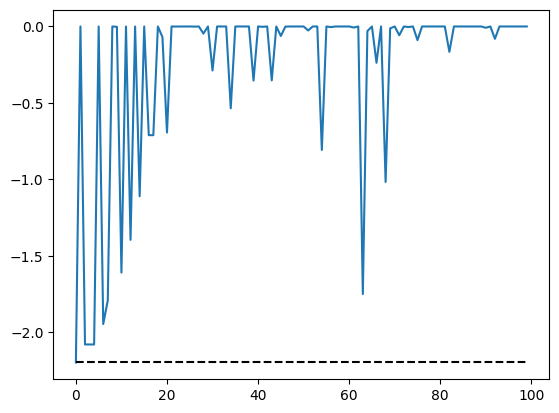

In [5]:
from simulate.compute_likelihood_full_actions import compute_predicted_actions
from simulate.generate_observations_full_actions import generate_synthetic_data



synth_data = generate_synthetic_data(ENVIRONMENT,agent.get_all_functions(hyperparams),
                                     10,000,True)
print(synth_data)
final_parameters,predicted_actions,(model_states,other_data) = compute_predicted_actions(
    synth_data,agent.get_all_functions(hyperparams),
)
logliks_dict,gt_ce_dict = compute_loglikelihood(synth_data,agent.get_all_functions(hyperparams),statistic='mean',return_params=False)


fig,ax = plt.subplots(1,1)
ax.plot(gt_ce_dict["angle"].reshape(-1,))



random_agent_options = {
    "model_family" : "random"  # "rw" / "latql" / "tracking_rw"
}
random_agent = Agent(random_agent_options,MODEL_CONSTANTS)
logliks_dict,random_ce_dict = compute_loglikelihood(synth_data,random_agent.get_all_functions(hyperparams),statistic='mean',return_params=False)
ax.plot(random_ce_dict["angle"].reshape(-1,),color='black',linestyle='--')






synth_data = vmap(lambda x: generate_synthetic_data(ENVIRONMENT,agent.get_all_functions(x),
                                     10,000,True))(hyperparams) # Add the "subject" dimension !

3
{'q_table': {'angle': Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace(level=6/0)>, 'distance': Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=6/0)>, 'position': Traced<ShapedArray(float32[9])>with<DynamicJaxprTrace(level=6/0)>}}
step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[20])>with<BatchTrace(level=1/0)> with
    val = Array([[450.3095 , 502.29163, 577.3766 , 381.53348, 522.93756, 559.0582 ,
        553.8461 , 575.6709 , 575.9068 , 568.9596 , 520.8889 , 546.8239 ,
        569.6975 , 549.2062 , 546.6809 , 670.5583 , 578.068  , 523.5191 ,
        571.2418 , 228.84421]], dtype=float32)
    batch_dim = 0
  batch_dim = 0
step 10, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[20])>with<BatchTrace(level=1/0)> with
    val = Array([[415.03928, 455.6676 , 575.87305, 333.51514, 517.3928 , 546.77155,
        537.9606 , 572.6959 , 572.39026, 562.77   , 

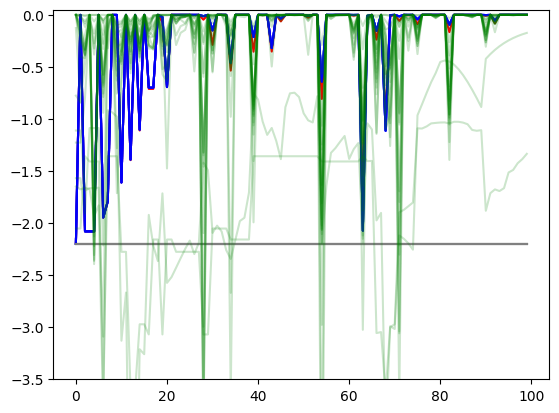

In [ ]:
# Inversion : 
from simulate.invert_model import invert_data_for_single_model

fig,ax = plt.subplots(1,1)
ax.plot(gt_ce_dict["angle"].reshape(-1,),color="red")




model_contents = {
    "agent" : agent
}
results =  invert_data_for_single_model(synth_data,model_contents,method="mle",
                                standard_n_heads = 20,standard_n_steps = 500,lr = 5e-2,
                                rngkey = jr.PRNGKey(0),option_verbose = True,
                                save=False ,save_directory = "default",override = False)
logliks_dict,ce_dict = results["logliks"]
for head in range(ce_dict["angle"].shape[1]):
    plt.plot(ce_dict["angle"][0,head].reshape(-1,),alpha = 0.2,color="blue")

model_contents = {
    "agent" : random_agent
}
results =  invert_data_for_single_model(synth_data,model_contents,method="mle",
                                standard_n_heads = 20,standard_n_steps = 1500,lr = 5e-2,
                                rngkey = jr.PRNGKey(0),option_verbose = True,
                                save=False ,save_directory = "default",override = False)
logliks_dict,ce_dict = results["logliks"]
for head in range(ce_dict["angle"].shape[1]):
    plt.plot(ce_dict["angle"][0,head].reshape(-1,),alpha = 0.2,color="grey")

# agent_options = {
#     "model_family" : "latql",  # "rw" / "latql" / "tracking_rw"
#     "free_parameters" : "mixed",
#     "biaises" : ["static","initial"],
#     "assymetric_learning_rate" : True,
#     "modality_selector" : None,
#     "generalizer" : False
# }
# other_agent = Agent(agent_options,MODEL_CONSTANTS)
# model_contents = {"model" : other_agent}
# results =  invert_data_for_single_model(synth_data,model_contents,method="mle",
#                                 standard_n_heads = 20,standard_n_steps = 1500,lr = 5e-2,
#                                 rngkey = jr.PRNGKey(0),option_verbose = True,
#                                 save=False ,save_directory = "default",override = False)
# logliks_dict,ce_dict = results["logliks"]
# for head in range(ce_dict["angle"].shape[1]):
#     plt.plot(ce_dict["angle"][0,head].reshape(-1,),alpha = 0.2,color="green")


agent_options = {
        "model_family" : "trw",
        "free_parameters" : "mixed",
        "biaises" : ["static","initial"],
        "assymetric_learning_rate" : True,
        "modality_selector" : {
            "learn" : True,
            "metric" : "js_controll", #"q_value","surprisal"
            "biaises" : ["initial"],
            "focused_learning" : True,
            "independent_focused_learning_weights" : True
        },
        "cross_state_generalize" : {
            "qtable": False,
            "transitions": False,
        }
    }
other_agent = Agent(agent_options,MODEL_CONSTANTS)
model_contents = {"agent" : other_agent}
results =  invert_data_for_single_model(synth_data,model_contents,method="mle",
                                standard_n_heads = 20,standard_n_steps = 1500,lr = 5e-2,
                                rngkey = jr.PRNGKey(0),option_verbose = True,
                                save=False ,save_directory = "default",override = False)
logliks_dict,ce_dict = results["logliks"]
for head in range(ce_dict["angle"].shape[1]):
    plt.plot(ce_dict["angle"][0,head].reshape(-1,),alpha = 0.2,color="green")



plt.ylim(-3.5,0.05)
    
print(logliks_dict['angle'])